<a href="https://colab.research.google.com/github/macr/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
# y = "health outcome" - predicted variable - dependent variable
# x = "drug usage" - explanatory variable - independent variable

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here
random.seed(10) # Random Seed for reproducibility

In [107]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [108]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=172.07500125969045, mobile=False), User(purchased=False, time_on_site=242.1604565076447, mobile=True), User(purchased=True, time_on_site=172.4562884302345, mobile=True), User(purchased=False, time_on_site=134.30741730988564, mobile=True), User(purchased=False, time_on_site=176.6659151415657, mobile=False), User(purchased=False, time_on_site=98.57704667574383, mobile=True), User(purchased=False, time_on_site=141.90635886960914, mobile=True), User(purchased=False, time_on_site=46.30954508769639, mobile=True), User(purchased=True, time_on_site=568.9570603645093, mobile=False), User(purchased=False, time_on_site=64.57737234489078, mobile=True)]


In [109]:
# !pip freeze
!pip install pandas==0.23.4

In [110]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,172.075001,False
1,False,242.160457,True
2,True,172.456288,True
3,False,134.307417,True
4,False,176.665915,False


In [111]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.167894147962072,5.230051694531813,5.859655940198439,6.0175026563650755,6.029351938631506,6.076534025386882,7.530625255773601,7.817115390608255,7.825127435732432,7.9926238138229575,...,582.0038712877167,585.1679472229359,588.9784218509578,589.6238169166027,594.952201290341,595.4861528820476,595.6859588006147,597.9686255982785,599.821842253337,599.9043999383127
purchased,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,0,1,1,1,1,1,0,...,1,1,0,1,1,1,0,0,1,0
True,1,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,1,1,0,1


In [0]:
# Let's use crosstabulation to try to see what's going on
# pd.crosstab(user_data['purchased'], user_data['time_on_site'], margins=True)

In [0]:
# Trying to show the margins on our Crosstab. Think this might be another 
# versioning issue.
# pd.crosstab(user_data['purchased'], time_bins, margins=True)

In [114]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.573, 124.115]","(124.115, 243.062]","(243.062, 362.01]","(362.01, 480.957]","(480.957, 599.904]"
purchased,,,,,
False,249,212,119,42,22
True,100,139,84,15,18


In [115]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.573, 124.115]","(124.115, 243.062]","(243.062, 362.01]","(362.01, 480.957]","(480.957, 599.904]"
purchased,,,,,
False,0.713467,0.603989,0.586207,0.736842,0.55
True,0.286533,0.396011,0.413793,0.263158,0.45


In [116]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.728,0.616
True,0.272,0.384


In [117]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], 
            rownames=['device'], 
            colnames=["purchased", "time on site"], 
            normalize='index')
ct

purchased               False                                       \
time on site (4.573, 124.115] (124.115, 243.062] (243.062, 362.01]   
device                                                               
False                0.172000           0.120000          0.180000   
True                 0.274667           0.242667          0.098667   

purchased                                                    True   \
time on site (362.01, 480.957] (480.957, 599.904] (4.573, 124.115]   
device                                                               
False                    0.168              0.088         0.036000   
True                     0.000              0.000         0.121333   

purchased                                                            \
time on site (124.115, 243.062] (243.062, 362.01] (362.01, 480.957]   
device                                                                
False                  0.056000             0.048              0.06   
True                   0.166667             0.096              0.00   

purchased                        
time on site (480.957, 599.904]  
device                           
False                     0.072  
True                      0.000

In [0]:
# help(user_data.plot)

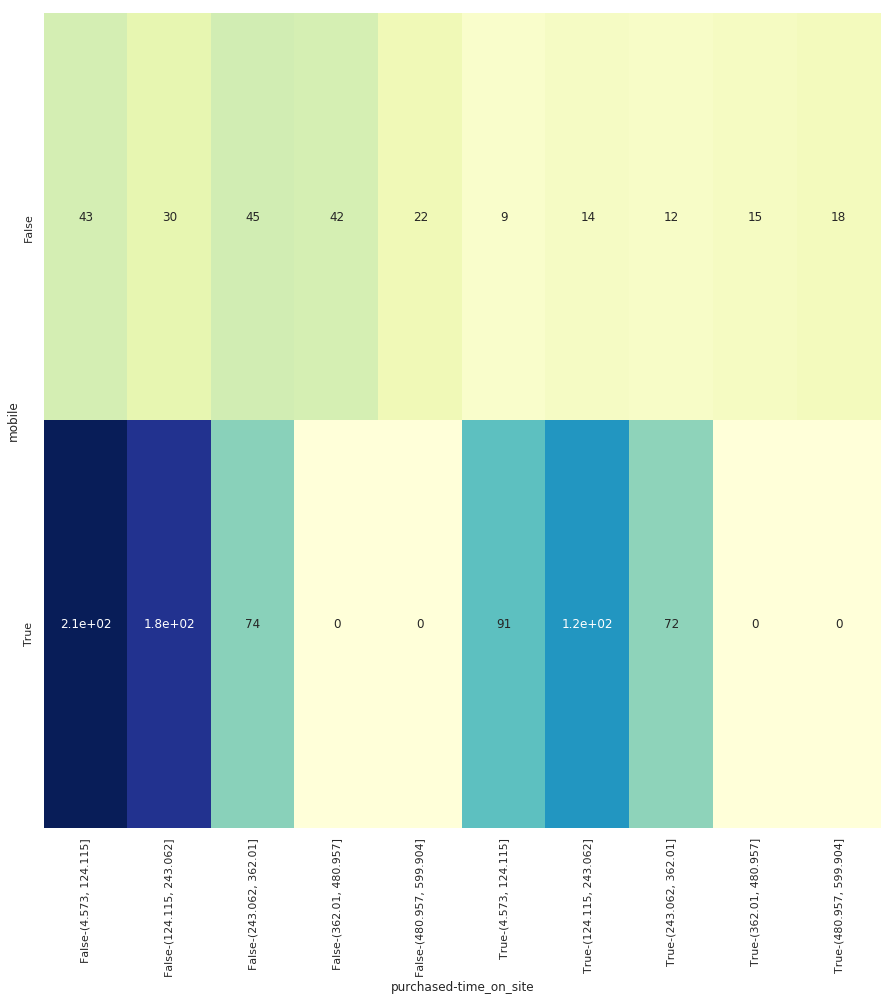

In [119]:
import seaborn as sns
sns.heatmap(pd.crosstab(user_data['mobile'],  [user_data['purchased'], time_bins] ),
            cmap="YlGnBu", annot=True, cbar=False)

In [0]:
# user_data.hist()

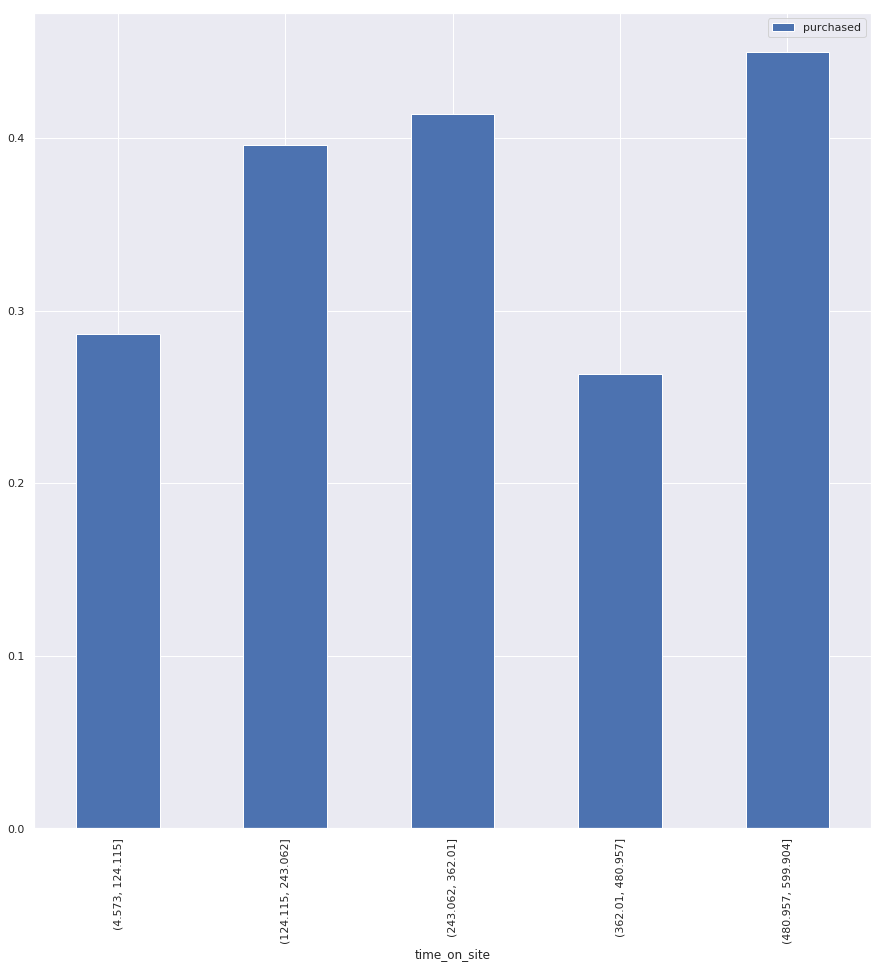

In [121]:
pd.pivot_table(user_data, values='purchased',
               index=time_bins).plot.bar()

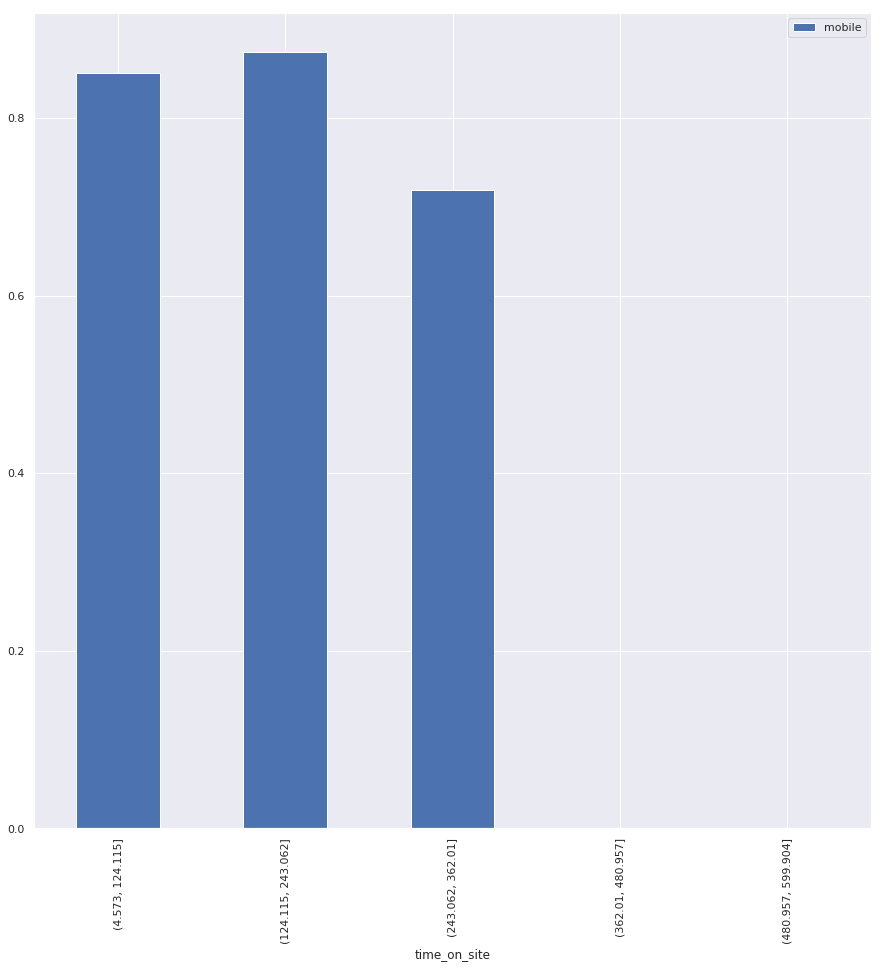

In [122]:
pd.pivot_table(
    user_data, values='mobile', index=time_bins).plot.bar();

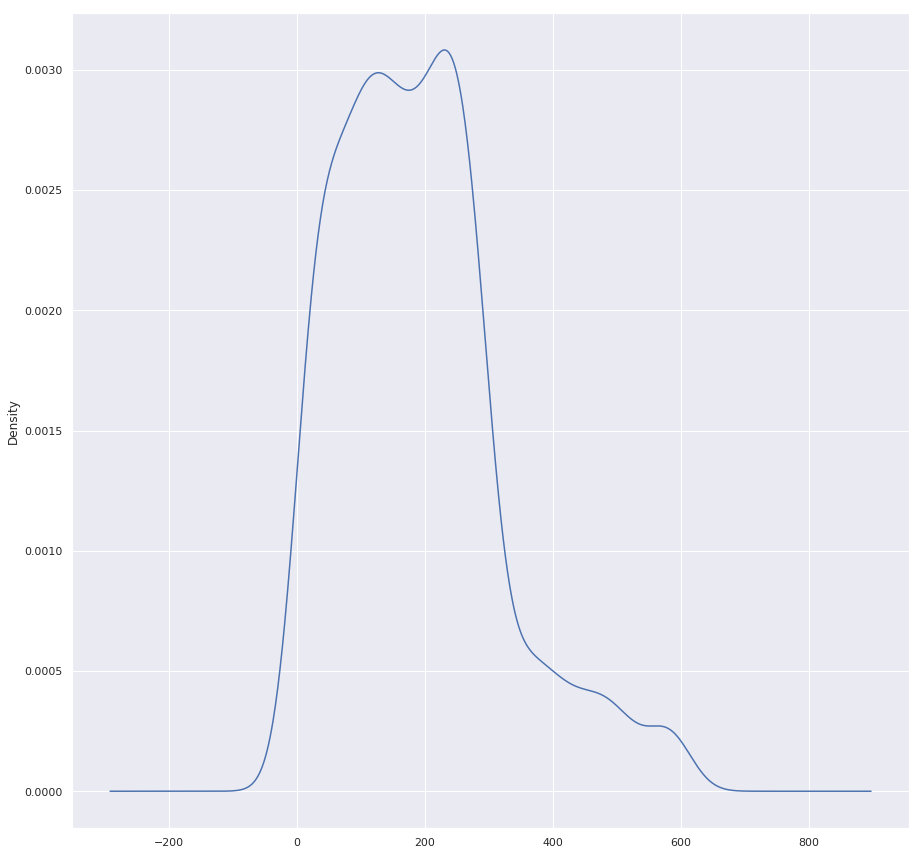

In [123]:
user_data['time_on_site'].plot.density();

In [124]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                 normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.573, 124.115]    0.236264  0.445887  0.132353  0.315972
(124.115, 243.062]  0.164835  0.393939  0.205882  0.434028
(243.062, 362.01]   0.247253  0.160173  0.176471  0.250000
(362.01, 480.957]   0.230769  0.000000  0.220588  0.000000
(480.957, 599.904]  0.120879  0.000000  0.264706  0.000000

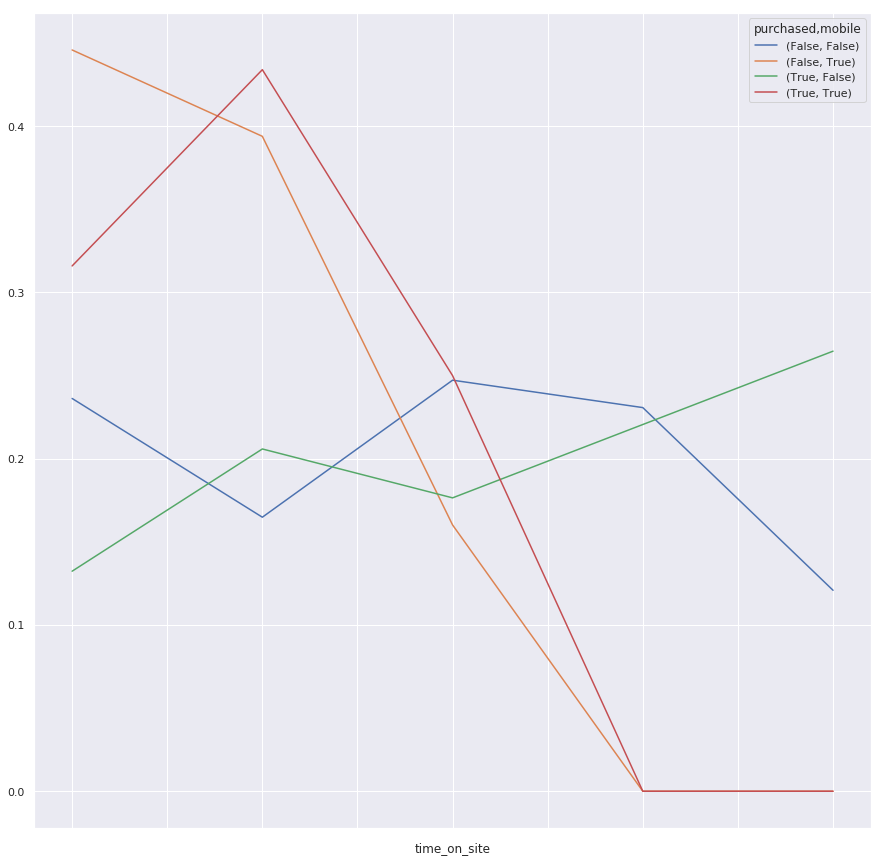

In [125]:
ct.plot();

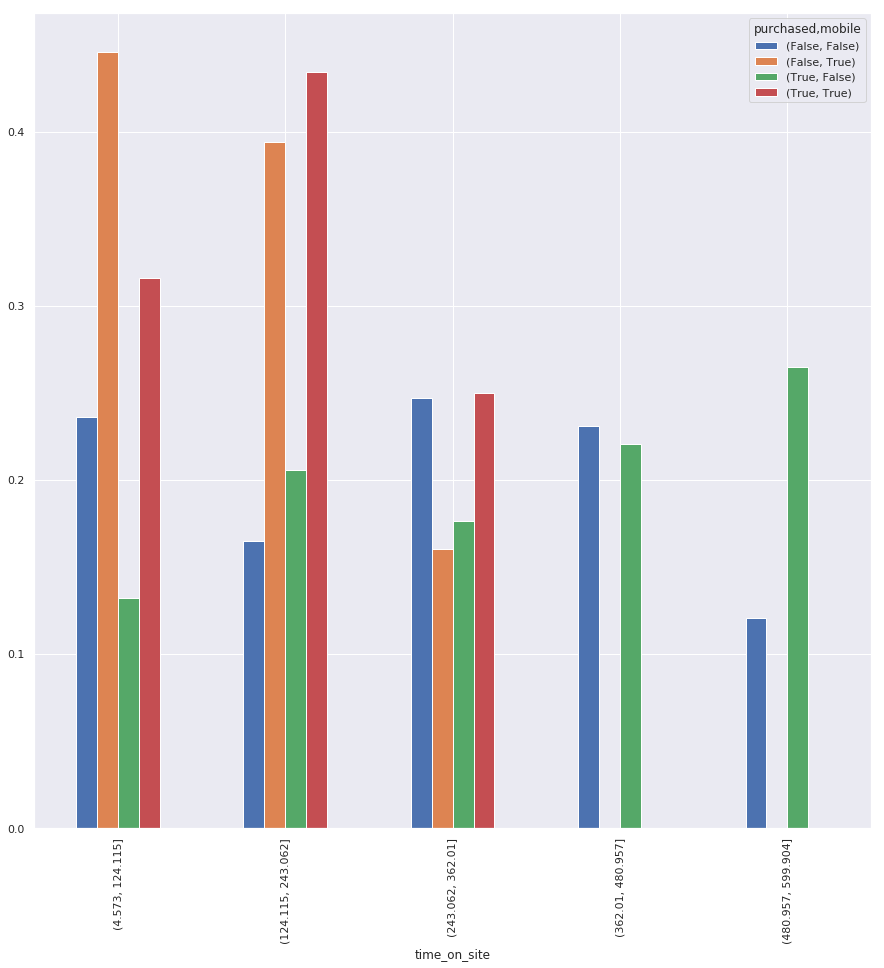

In [126]:
ct.plot(kind='bar')

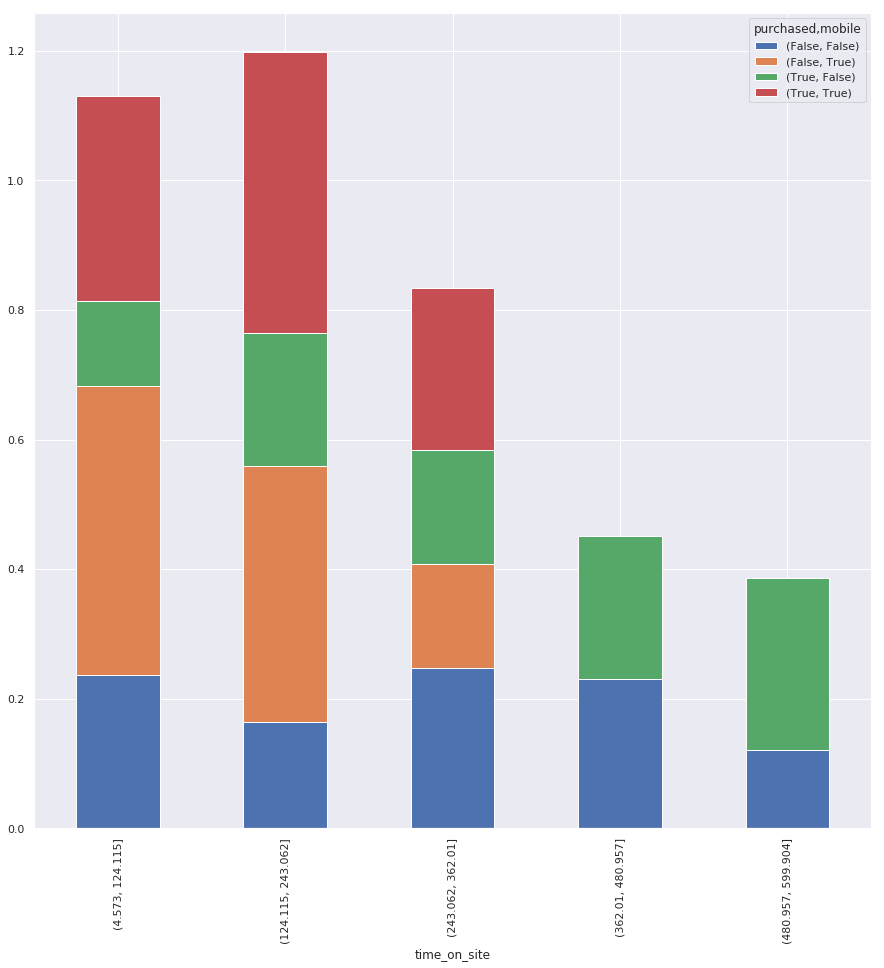

In [127]:
ct.plot(kind='bar', stacked=True)

In [128]:
time_bins = pd.cut(user_data['time_on_site'], 6)  # 6 equal-sized bins
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                 normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.573, 104.291]    0.181319  0.376623  0.073529  0.250000
(104.291, 203.413]  0.142857  0.333333  0.161765  0.340278
(203.413, 302.536]  0.192308  0.290043  0.220588  0.409722
(302.536, 401.659]  0.225275  0.000000  0.147059  0.000000
(401.659, 500.782]  0.164835  0.000000  0.176471  0.000000
(500.782, 599.904]  0.093407  0.000000  0.220588  0.000000

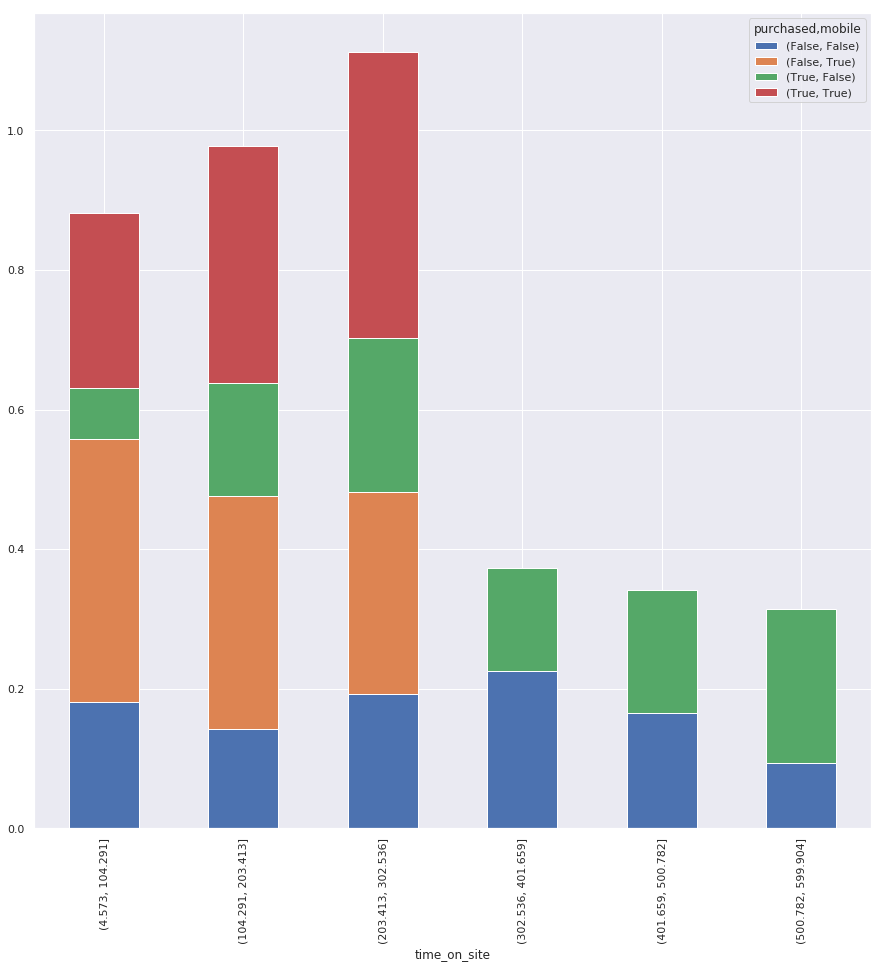

In [129]:
ct.plot(kind='bar', stacked=True)

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [130]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
df = pd.read_csv('https://raw.githubusercontent.com/DylanGraves/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')

df = df.drop(['Unnamed: 0'], axis=1)
df.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


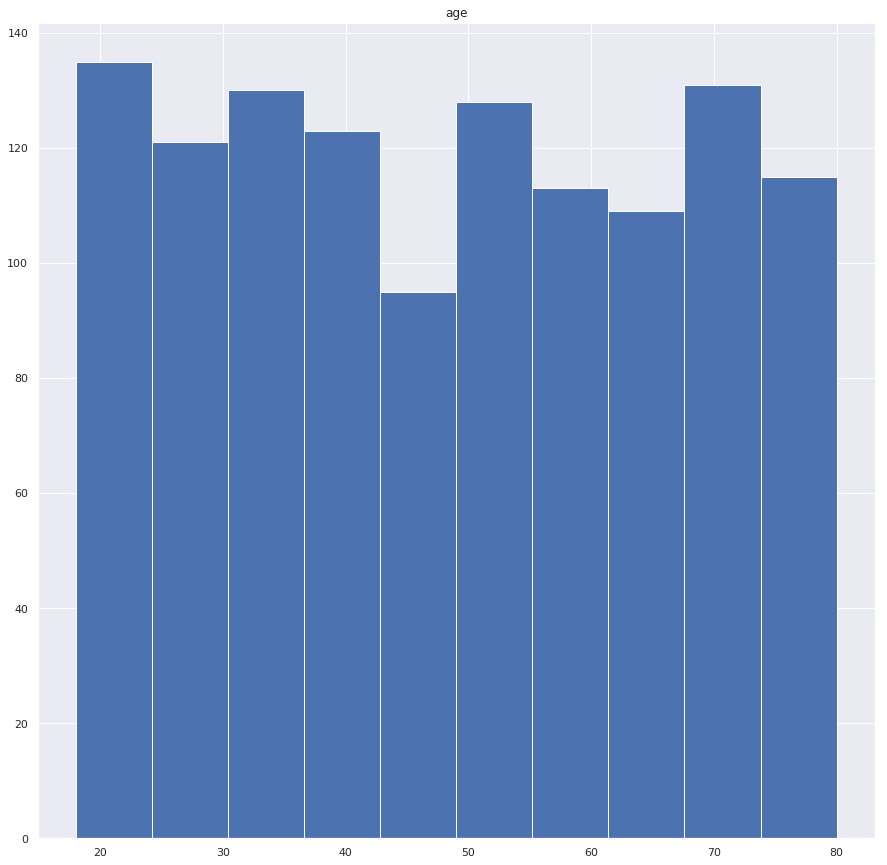

In [131]:
df.hist('age');

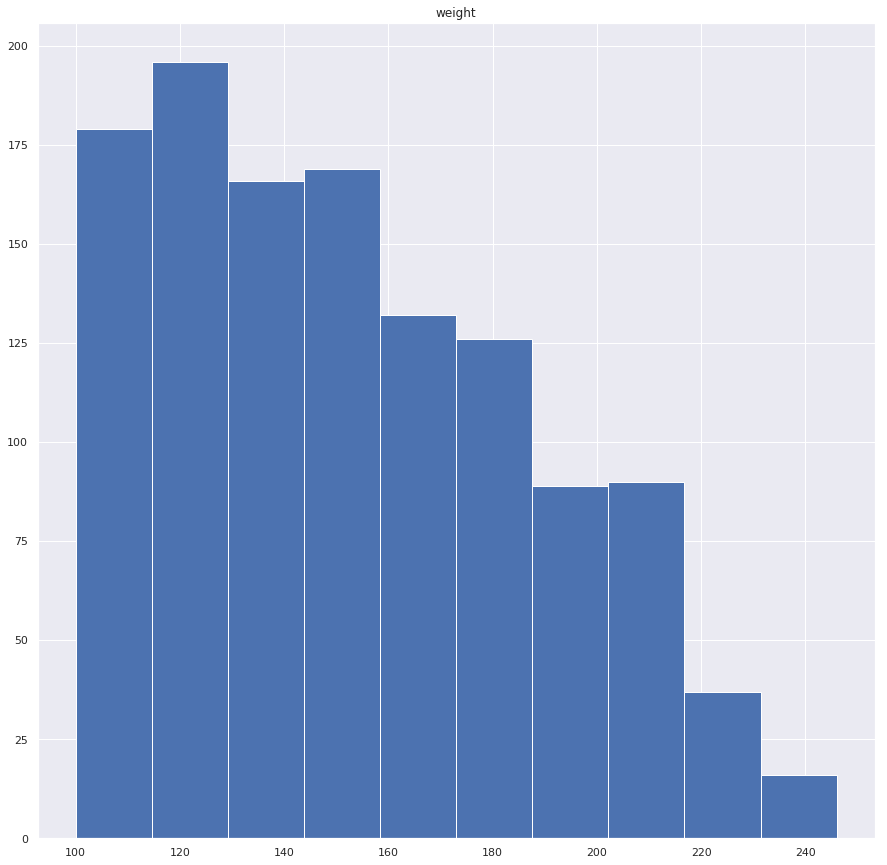

In [132]:
df.hist('weight');

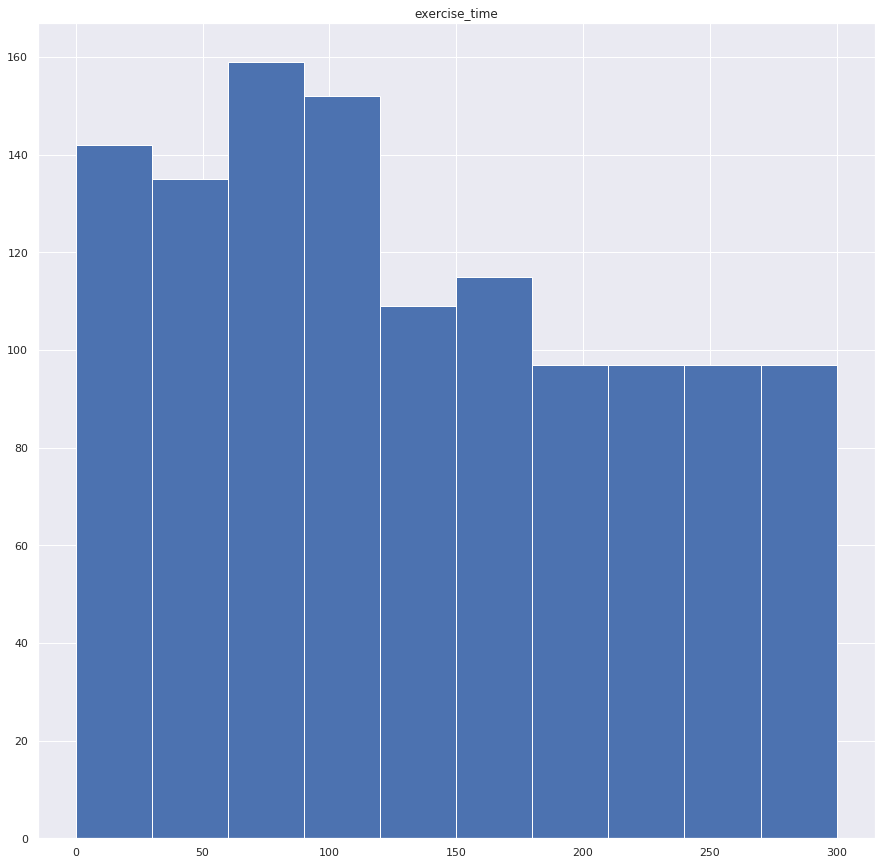

In [133]:
df.hist('exercise_time');

In [134]:
df.corr()

,age,weight,exercise_time
age,1.000000,0.144168,-0.273818
weight,0.144168,1.000000,-0.478021
exercise_time,-0.273818,-0.478021,1.000000


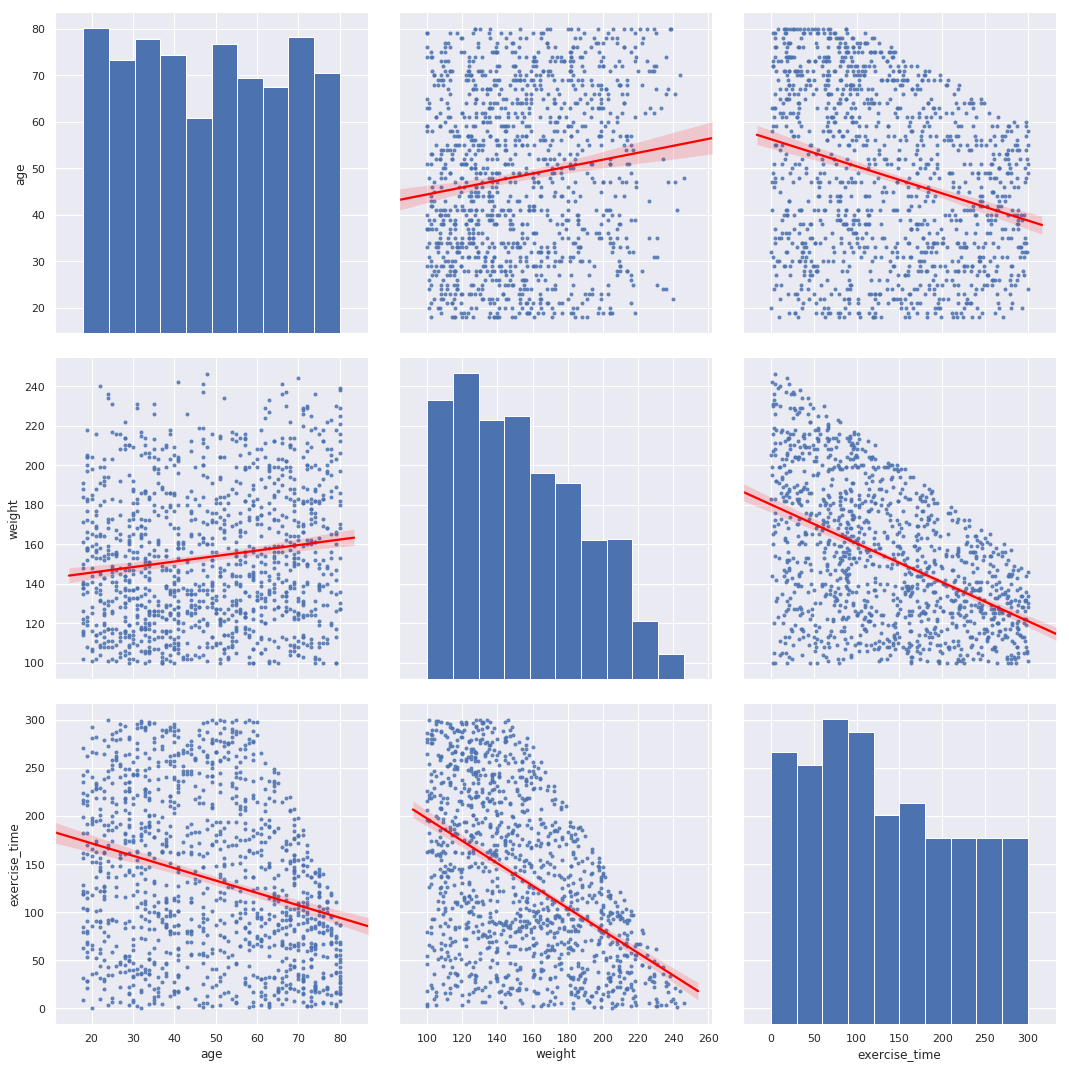

In [135]:


graph = sns.pairplot(df, markers='.', kind='reg', plot_kws={'line_kws':{'color':'red'}}, height=5)
#https://stackoverflow.com/questions/31568874/how-to-change-the-line-color-in-seaborn-linear-regression-jointplot

In [136]:
age_bins = pd.cut(df['age'], 6)  
weight_bins = pd.cut(df['weight'], 5) 
exercise_bins = pd.cut(df['exercise_time'], 6)
pd.crosstab(exercise_bins, age_bins, normalize='columns')

age,"(17.938, 28.333]","(28.333, 38.667]","(38.667, 49.0]","(49.0, 59.333]","(59.333, 69.667]","(69.667, 80.0]"
exercise_time,,,,,,
"(-0.3, 50.0]",0.138756,0.221198,0.135,0.141304,0.229167,0.338384
"(50.0, 100.0]",0.167464,0.147465,0.200,0.163043,0.276042,0.373737
"(100.0, 150.0]",0.157895,0.133641,0.125,0.157609,0.171875,0.227273
"(150.0, 200.0]",0.215311,0.193548,0.130,0.157609,0.187500,0.060606
"(200.0, 250.0]",0.186603,0.156682,0.180,0.130435,0.114583,0.000000
"(250.0, 300.0]",0.133971,0.147465,0.230,0.250000,0.020833,0.000000


In [137]:
exercise_bins = pd.cut(df['exercise_time'], 6)
pd.crosstab(weight_bins, exercise_bins, normalize='columns')

exercise_time,"(-0.3, 50.0]","(50.0, 100.0]","(100.0, 150.0]","(150.0, 200.0]","(200.0, 250.0]","(250.0, 300.0]"
weight,,,,,,
"(99.854, 129.2]",0.182573,0.181818,0.309278,0.342105,0.432258,0.583333
"(129.2, 158.4]",0.161826,0.242424,0.206186,0.352632,0.412903,0.391026
"(158.4, 187.6]",0.215768,0.284091,0.278351,0.257895,0.154839,0.025641
"(187.6, 216.8]",0.273859,0.242424,0.206186,0.047368,0.000000,0.000000
"(216.8, 246.0]",0.165975,0.049242,0.000000,0.000000,0.000000,0.000000


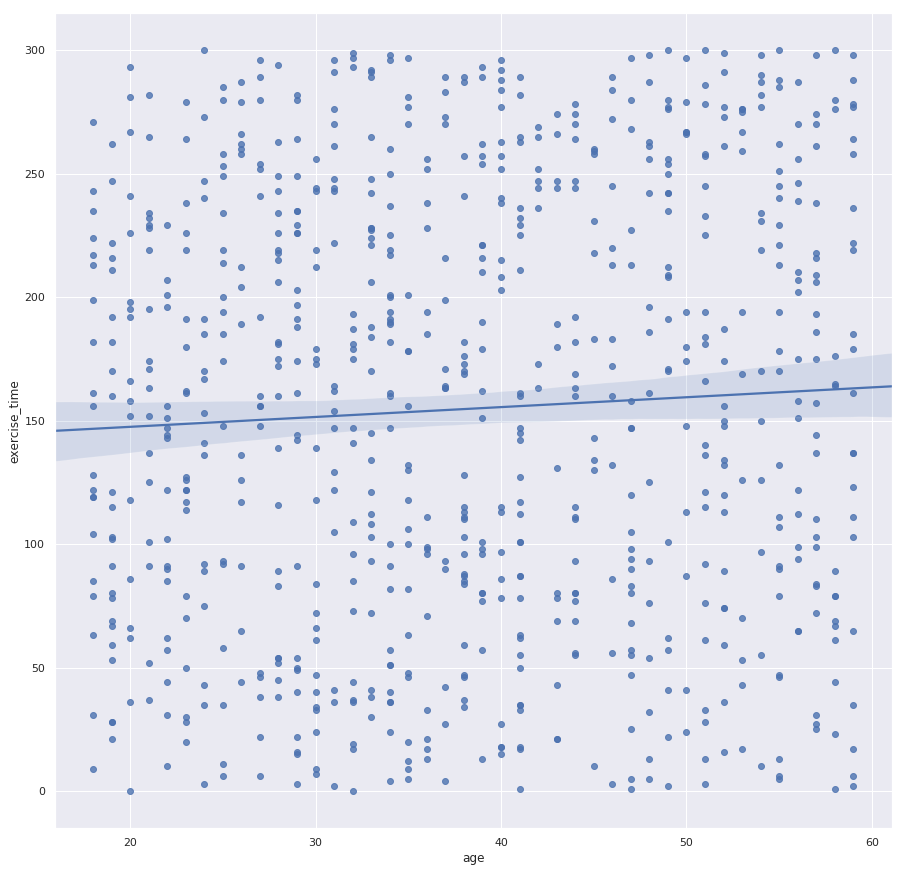

In [138]:
under_60 = df[df['age'] < 60]
sns.regplot(under_60['age'], under_60['exercise_time']);

In [142]:
from scipy import stats
import numpy as np
x = under_60['exercise_time']
y = under_60['age']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print('slope %s'% slope)
print('intercept %s'% intercept)
print('p_value %s'% p_value)
print('r_value %s'% r_value)
print('std_err %s'% std_err)
under_60.describe()

slope 0.007518328025154265
intercept 36.92455969360984
p_value 0.11918226894987587
r_value 0.05479358069890909
std_err 0.004819843954970077


,age,weight,exercise_time
count,810.000000,810.000000,810.000000
mean,38.087654,149.604938,154.701235
std,12.069984,33.811767,87.966055
min,18.000000,100.000000,0.000000
25%,28.000000,122.000000,80.000000
50%,38.000000,144.000000,160.000000
75%,49.000000,173.000000,234.000000
max,59.000000,246.000000,300.000000


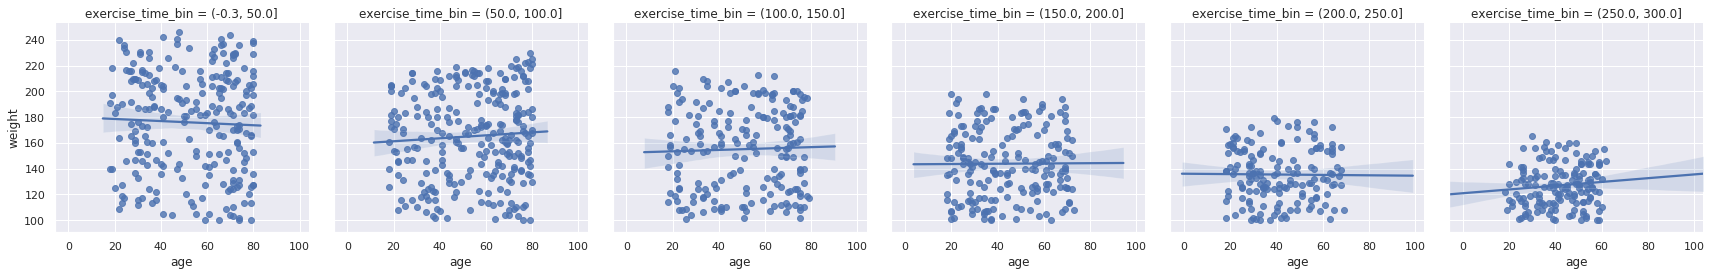

In [155]:
#relationship of age and weight; control for excercise_time
df['age_bin'] = age_bins
df['weight_bin'] = weight_bins
df['exercise_time_bin'] = exercise_bins
df.head()

g = sns.FacetGrid(df, col="exercise_time_bin", height=4)
g.map(sns.regplot, "age", "weight");

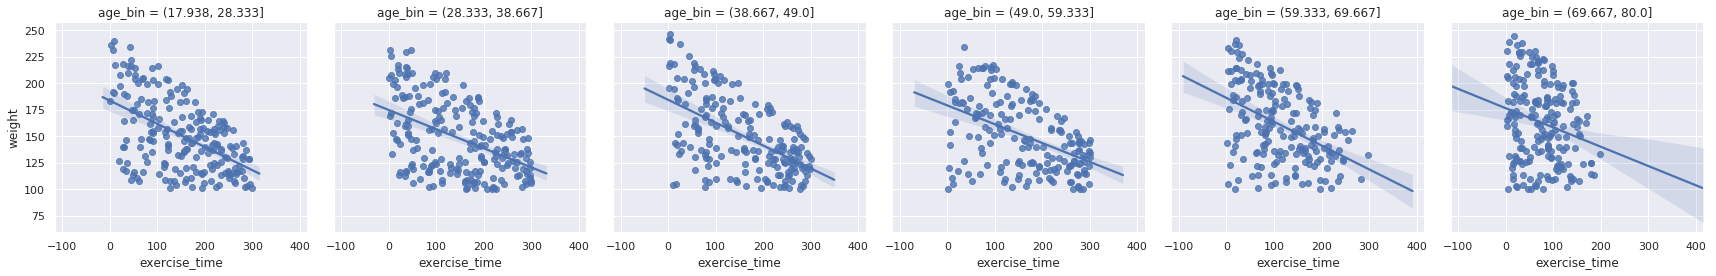

In [156]:
#relationship of exercise_time and weight; control for age
g = sns.FacetGrid(df, col="age_bin", height=4)
g.map(sns.regplot, "exercise_time", "weight");

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
  
  **All are continuous.**
2.  What are the relationships between the variables?
  
  **There is a negative correlation between exercise time and weight**  **At first sight there might seem to be a negative relationship between age and exercise time but if we inspect further we can see that the sharp decline in exercise time manifests after age 60. In fact there is even a slight positive correlation(actually insignificant) between age and exercise time for age<60**
  
  
3.  Which relationships are "real", and which spurious?
  
  ** The realtionship between excercise_time and excercise shows a strong correlation and is independent of age while the correlation of age to weight disappears when you control for exercise time **

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)
- Use a groupby object to create some useful visualizations